In [1]:
#Let us UPLOAD the desired libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import math
from matplotlib.animation import FuncAnimation
np.set_printoptions(precision=15, suppress=False) #stablish the output number of decimals
import scipy.special as sp
import scipy.signal as signal
from scipy.optimize import root
!pip install numdifftools #necessary to compute numerical derivatives

## Computation of Neural System ODEs: E-I with an excitatory input

In [2]:
# The parameters we consider are as follows. For their biological significance, please refer to the thesis.
tau_e = 8
tau_i = 8
tau_se = 1
tau_si = 5
Jee = 0
Jii = 0
Jie = 13
Jei = 13
Delta_e = 1
Delta_i = 1
eta_e = -5
eta_i = -5
I_bar_e = 10
I_bar_i = 0

# Initial condition: Taken from "Communication through coherence in a realistic neuronal model" by David Reyner Parra.
x0_david = [0.085262756825722,
1.125737037325799,
0.000000000000000,
0.209748707974244,
0.012828206758546,
-1.136491592341226,
0.834230210263032,
0.000000000000000]

# Neural network system of ODEs for the unperturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network_notperturbed(x, t):

    # Compute the total external input to the neurons
    I_e = I_bar_e + tau_e * x[2] - tau_e * x[3]
    I_i = I_bar_i + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1/tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1/tau_e) * (x[1]**2 + eta_e + I_e - (tau_e * np.pi * x[0])**2),  # Ve
        (1/tau_se) * (-x[2] + Jee * x[0]),  # See
        (1/tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1/tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1/tau_i) * (x[5]**2 + eta_i + I_i - (tau_i * np.pi * x[4])**2),  # Vi
        (1/tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1/tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt

In [3]:
# The following code implements the Poincaré section. 
#The theoretical background is explained in the appendix of the thesis.


def g(x):
    return x[1]

def approximation_tau_dir(system,x0,g,atol,rtol,dir, plot,estimated_period):
  if dir == 1 : t = np.linspace(0, estimated_period, 500)
  elif dir == -1 : t = np.linspace(0, -estimated_period, 500)
  sol_simp = odeint(system, x0, t,atol=atol, rtol=rtol)
  x_i=sol_simp[1]
  for i, xi in enumerate(sol_simp[1:], start=1):  # We do not consider the first element (to avoid problems if x0 belongs to Sigma)
        if g(x_i) * g(xi) <= 0:  # Verify if the product changes sign or is equal to zero
            t0 = t[i]  # Time correponding to the crossing value
            #print(xi)  # Print the point where the crossing occurs
            break
        x_i = xi  # Update the value of x_i

  if plot == 1:
    # Plot the solution in the xy-plane
    plt.figure(figsize=(4, 4))
    plt.plot(sol_simp[:,0], sol_simp[:,1])
    plt.xlabel('$r_e$ (kHz)')
    plt.ylabel('$V_e$ (mV)')
    plt.title('Peridic oscillator ')
    plt.grid(True)
    plt.show()


  return [xi,t0]

# One iteration of Newton's method
def DeltaT(x0):
    I_e = I_bar_e + tau_e * x0[2] - tau_e * x0[3]
    Ve=(1/tau_e) * (x0[1]**2 + eta_e + I_e - (tau_e * np.pi * x0[0])**2)
    return - g(x0) / Ve

# Function to evaluate the system's solution at a given direction and time
def evaluate(system, x0, h, dir, atol, rtol):
    if dir == 1: t = np.linspace(0, h, 100)  # Small time step. Forward integration
    if dir == -1 : t = np.linspace(0, -h, 100) # Backward integration
    sol = odeint(system, x0, t, atol=atol, rtol=rtol)
    return sol[-1]

def poincare_map_n_periodic(system, x0,n, tol, atol, rtol,dir,plot,estimated_period):
    points = np.zeros((n, 8))  # To store intersection points
    X0=x0
    total_time = 0
    for i in range(n):
        # Use last intersection point as new initial condition
      if i != 0: x0 = xk
      approx = approximation_tau_dir(neural_network_notperturbed,x0,g,atol,rtol,dir,plot,estimated_period)
      xk = approx[0]
      total_time += approx[1]

      # Refine the intersection using Newton's method
      while abs(g(xk)) > tol:
            deltaT = DeltaT(xk)
            total_time += deltaT
            if deltaT < 0:
                  xk = evaluate(system, xk, abs(deltaT), -1, atol, rtol)
            else:
                  xk = evaluate(system, xk, abs(deltaT), 1, atol, rtol)
      points[i, :] = xk  # Store the refined intersection point

    return points,total_time, points[-1]


In [4]:
# The following code is used to find a point that belongs to the oscillator and calculate its period T*.


t = np.linspace(0, 350, 2500)
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, x0_david, t, atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 300  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)

# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
x0=sol[-1]

P_0= poincare_map_n_periodic(neural_network_notperturbed, x0,1, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[2]

def Poincare(x):
    result = poincare_map_n_periodic(
        neural_network_notperturbed,
        x,
        n=2,
        tol=tol,
        atol=atol,
        rtol=rtol,
        dir=1,
        plot=0,
        estimated_period=estimated_period
    )[2]-x
    return result

# Find the root of the Poincaré map
result = root(Poincare, P_0,method='hybr')

# Check and display the result of the root-finding process
if result.success:
    print(f"Root found: {result.x}")
else:
    print("No root found.")

P_1=result.x
Period = poincare_map_n_periodic(neural_network_notperturbed,P_1 ,2, tol, atol, rtol, dir=1,plot=0,estimated_period=estimated_period)[1]
print(f"Period of the oscillator, T* = {Period}")

Root found: [ 2.464796620183146e-02  1.167705011074589e-23  4.732717671413217e-30
  2.970676711526801e-01  1.048186004864776e-02 -1.841054850356672e+00
  2.716710240600461e-01  0.000000000000000e+00]
Period of the oscillator, T* = 24.23496887842161


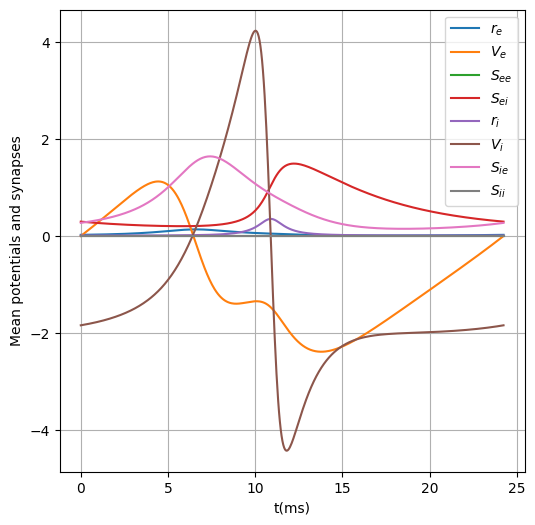

In [5]:
#Graphic representation of the oscillator
t = np.linspace(0, Period, 500)

# Parameters
tol = 1e-16  # Tolerance for Newton's method
atol = 1e-17  # Absolute tolerance for ODE integration
rtol = 1e-13  # Relative tolerance for ODE integration

sol = odeint(neural_network_notperturbed, P_1, t, atol=atol, rtol=rtol)


plt.figure(figsize=(6, 6))
plt.plot(t,sol[:,0],label=r'$r_e$')
plt.plot(t,sol[:,1],label=r'$V_e$')
plt.plot(t,sol[:,2],label=r'$S_{ee}$')
plt.plot(t,sol[:,3],label=r'$S_{ei}$')
plt.plot(t,sol[:,4],label=r'$r_i$')
plt.plot(t,sol[:,5],label=r'$V_i$')
plt.plot(t,sol[:,6],label=r'$S_{ie}$')
plt.plot(t,sol[:,7],label=r'$S_{ii}$')
plt.ylabel('Mean potentials and synapses')
plt.xlabel('t(ms)')
plt.grid(True)
plt.legend()
plt.show()

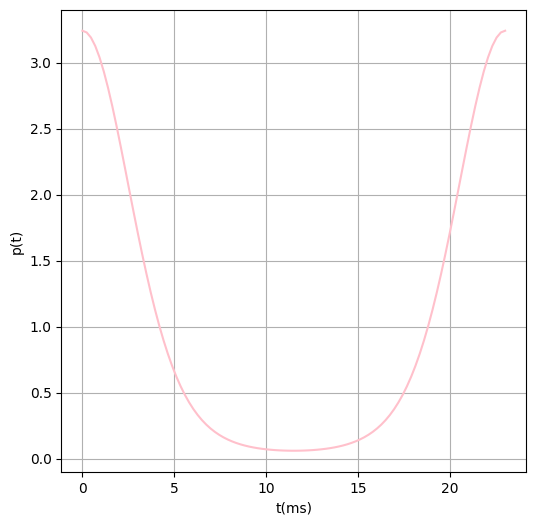

Estimated period of r_e (after transient): 23.01534356237491 seconds


In [6]:
#Define the excitatory input with mu=0 and coherence kappa=2

# Parameters
mu = 0
k = 2 #Change the parameter kappa to compute other arnold tongues (such as k=20)

# External input function 
def p(t,T):
    I0_value = sp.iv(0, k)  # modified Bessel function of order 0
    return T * (np.exp(k * np.cos(((2 * np.pi) * (t - mu)) / T))) / (T * I0_value)

vals_t=np.linspace(0,0.95*Period,100)
y = [p(val, 0.95*Period) for val in vals_t]  # Map values for y-axis


plt.figure(figsize=(6, 6))
plt.plot(vals_t, y, color='pink')
plt.ylabel('p(t)')
plt.xlabel('t(ms)')
plt.grid(True)
plt.show()




# Neural network system of ODEs for the perturbed system. 
#For details on their biological significance, please refer to the thesis.
def neural_network(x, t,A,T):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * A * p(t,T)
    I_i_ext = I_bar_i + tau_i * A * p(t,T)

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt


# Time span for integration
t = np.linspace(0, 150, 1500)

# Solve the system of equations
atol = 1e-17
rtol = 1e-13

sol = odeint(neural_network, P_1, t, args =(0.2,23,), atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 100  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)
#print(t[peaks[-1]])
# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
print(f"Estimated period of r_e (after transient): {estimated_period} seconds")

### Phase equation


In [7]:
# The following code implements the definitions needed to compute the iPRC.

from scipy.interpolate import interp1d

# Jacobian of the system F(x)
def jacobian(x):
    # Jacobian matrix of the neural network system
    jacobian_matrix = np.zeros((8, 8))

    jacobian_matrix[0, 0] = (1 / tau_e) * (2 * x[1])  # df0/dx0
    jacobian_matrix[0, 1] = (1 / tau_e) * (2 * x[0])  # df0/dx1
    jacobian_matrix[1, 0] = (-2 * (np.pi**2)*x[0]*tau_e)  # df1/dx0
    jacobian_matrix[1, 1] = (1 / tau_e) * (2 * x[1])  # df1/dx1
    jacobian_matrix[1, 2] = 1  # df1/dx2
    jacobian_matrix[1, 3] = -1  # df1/dx3
    jacobian_matrix[2, 0] = (1 / tau_se) * Jee        # df2/dx0
    jacobian_matrix[2, 2] = (-1 / tau_se)       # df2/dx2
    jacobian_matrix[3, 3] = (-1 / tau_si)   # df3/dx3
    jacobian_matrix[3, 4] = (1 / tau_si) * Jei        # df3/dx4
    jacobian_matrix[4, 4] = (1 / tau_i) * (2 * x[5])  # df4/dx4
    jacobian_matrix[4, 5] = (1 / tau_i) * (2 * x[4])  # df4/dx5
    jacobian_matrix[5, 4] = (-2 * (np.pi**2)*x[4]*tau_i)  # df5/dx4
    jacobian_matrix[5, 5] = (1 / tau_i) * (2 * x[5])  # df5/dx5
    jacobian_matrix[5, 6] = 1 # df5/dx6
    jacobian_matrix[5, 7] = -1 # df5/dx7
    jacobian_matrix[6, 0] = (1 / tau_se) * Jie        # df6/dx0
    jacobian_matrix[6, 6] = (-1 / tau_se)         # df6/dx6
    jacobian_matrix[7, 4] = (1 / tau_si) * Jii        # df7/dx4
    jacobian_matrix[7, 7] = (-1 / tau_si)       # df7/dx7


    return -jacobian_matrix.T


# Define the matrix differential equation as a vector-valued function
def adjoint_equation(X_flat, t, interp_orbit):
    # Reshape the flat vector back into the matrix form (8x8 in this case)
    X = X_flat.reshape((8, 8))  # Adjust the shape for your matrix size

    # Interpolate the state x(t) from the periodic orbit at time t
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ X

    # Flatten the result back into a vector
    return dX_dt.flatten()


# Define the vectorial differential equation 
def vector_adjoint_equation(x, t, interp_orbit):
    x_t = interp_orbit(t)  # Interpolate each x component

    # Compute the Jacobian at x(t)
    J_t = jacobian(x_t)

    # Compute the derivative of the matrix dX/dt = A(t) * X
    dX_dt = J_t @ x

    # Flatten the result back into a vector
    return dX_dt

#INTEGRATION OF THE PHASE EQUATION
def phase_equation(x, t, interp_orbit_iPRC,A,T):
    z_t = interp_orbit_iPRC(x % Period)  # Interpolate z_t theta

    # Compute the phase equation (wrapped modulo Period)
    dtheta = 1 +  (z_t[1] + z_t[5]) * A * p(t,T)
    return dtheta



[ 3.350528010569331e+10   +0.j
  1.273569502215331e+02   +0.j
  2.306084684648447e+10   +0.j
  2.099193194703150e+05   +0.j
 -1.558575267619474e+03+1579.7595537080992j
 -1.558575267619474e+03-1579.7595537080992j
  1.000003401601122e+00   +0.j
  1.487951926690072e+01   +0.j             ]


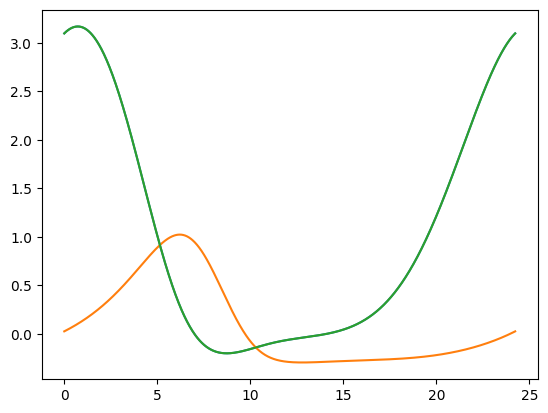

In [8]:
#ALL THIS COMPUTATITIONS ARE INTRINSIC OF THE OSCILLATOR (do not depend on theta,T,A)
# The following code implements the computation of the iPRC.

x_0 = P_1  # Initial condition for the periodic orbit (assumed to be defined)

t = np.linspace(0, Period, 1000)

# Integrate the periodic orbit
orbit_solution = odeint(neural_network_notperturbed, x_0, t, atol=atol, rtol=rtol)
interp_orbit_oscillator = interp1d(t, orbit_solution.T, kind='cubic', fill_value='extrapolate')

# Initial condition for the fundamental matrix (identity matrix)
A0 = np.eye(8).flatten()
t_vals = np.linspace(0, Period, 1000)

# Integrate the adjoint equation for the fundamental matrix
sol = odeint(adjoint_equation, A0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
A_T = sol[-1].reshape(8, 8)
eigenvalues, eigenvectors = np.linalg.eig(A_T)
print(eigenvalues)
real_eigenvalues = np.real(eigenvalues)
closest_index = np.argmin(np.abs(real_eigenvalues - 1))
v_0 = np.real(eigenvectors[:, closest_index])
alpha = 1 / (v_0 @ neural_network_notperturbed(x_0, 0))
V_0 = alpha * v_0

# Integrate the adjoint equation for the phase response curve
sol_phi_t = odeint(vector_adjoint_equation, V_0, t_vals, args=(interp_orbit_oscillator,), atol=atol, rtol=rtol)
interp_orbit_iPRC = interp1d(t_vals, sol_phi_t.T, kind='cubic', fill_value='extrapolate')


plt.plot(t_vals,sol_phi_t[:,1],label=r'$iPRC-V_e$')
plt.plot(t_vals,sol_phi_t[:,5],label=r'$iPRC-V_i$')

t=np.linspace(0,Period,1000)
plt.plot(t,interp_orbit_iPRC(t)[1])


In [12]:
# Define the stroboscopic map function with updated parameters (x, A, T)
def stroboscopic_map(x, A, T,interp_orbit_iPRC):

    # Integrate the phase equation with the initial condition x
    t_phase = np.linspace(0, T, 1000)
    sol_theta_t = odeint(phase_equation, x, t_phase, args=(interp_orbit_iPRC, A, T), atol=atol, rtol=rtol)
    Theta_n = sol_theta_t[-1] % Period

    return Theta_n[0] #to ensure that it is an scalar



theta_n=18
#print(T/Period)
for i in range(1,50):
  theta_n=stroboscopic_map(theta_n,0.05,0.95*Period, interp_orbit_iPRC)
  print(theta_n)

17.455507150646213
16.746469293834792
15.857382000627226
14.798030693792633
13.6160875325468
12.398937189255044
11.252764945514969
10.259939231493064
9.451601978329748
8.822476935649675
8.34998955833759
8.004458350852921
7.756302113876753
7.58013257324566
7.455970500208338
7.36885883914519
7.30791734866337
7.265363147321747
7.235684666510323
7.215002895828988
7.200598476225601
7.190569837435628
7.183589483038887
7.17873171468495
7.175351505429074
7.172999631545181
7.171363345213251
7.170224965635182
7.1694330065051695
7.168882059254361
7.168498783502727
7.1682321536891145
7.168046671100008
7.167917639634236
7.16782787879864
7.167765436773841
7.167721999106693
7.167691781762759
7.167670761198131
7.16765613829342
7.167645966023095
7.167638889666332
7.167633967037261
7.167630542627645
7.167628160456719
7.1676265032845805
7.167625350493719
7.167624548563779
7.167623990709075


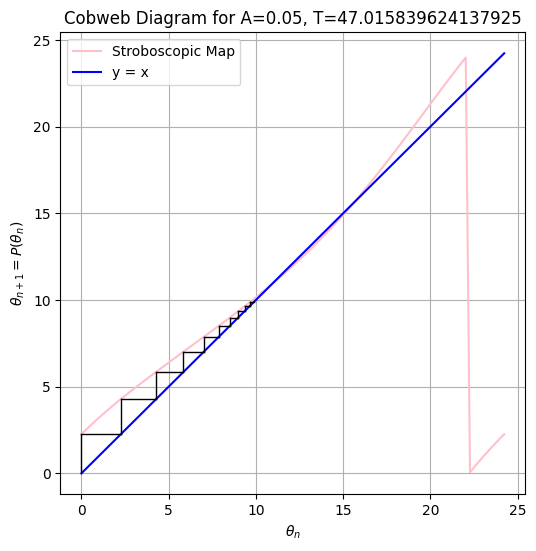

In [13]:
# Let us define a function to generate a COBWEB plot
def cobweb_plot(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [stroboscopic_map(val, A, T, interp_orbit_iPRC) for val in x]  # Map values for y-axis

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic Map', color='pink')
    plt.plot(x, x, label='y = x', color='blue')

    # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = stroboscopic_map(x_n, A, T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot(0, 1.94*Period, 0.05, 10)


### Computation of Arnold Tongues for $\kappa=\infty$

3.298359240670708
-0.35477397690636425


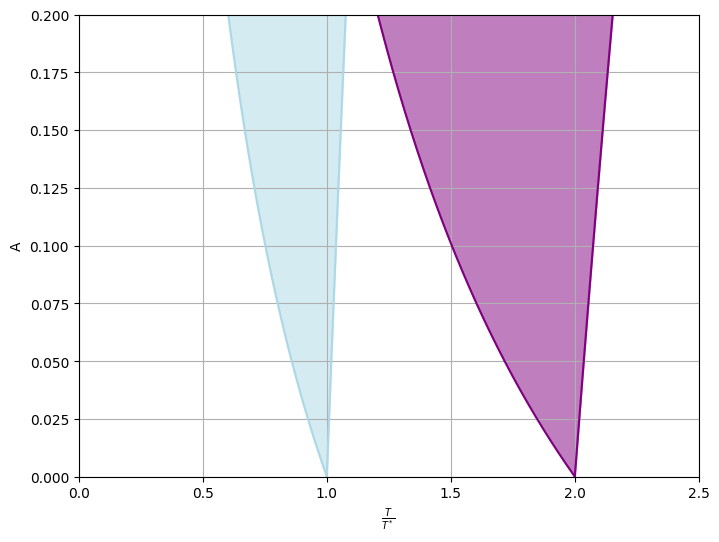

In [9]:
# The following code calculates the 1:1 and 2:1 Arnold tongues for pulsatile inputs.


time_points = np.linspace(0, Period, 1000)  # Sample points across one period
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC over these points

# Extract components 1 and 5, and calculate their sum
Z_values = interp_values[1] + interp_values[5]  # Sum of component 1 and component 5

# Calculate Zmax and Zmin
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)
print(Zmax)
print(Zmin)

# Define the range for A and calculate corresponding T/T* values
A_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 + A_values * Zmax
T_over_Tstar_min = 1 + A_values * Zmin

T_over_Tstar_max_2 = (1/2)*(1 + A_values * Zmax)
T_over_Tstar_min_2 = (1/2)*(1 + A_values * Zmin)


# Plotting
plt.figure(figsize=(8, 6))

# Fill the region between the two curves
plt.fill_betweenx(A_values, 1/T_over_Tstar_min, 1/T_over_Tstar_max, color='lightblue', alpha=0.5)

# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max, A_values, color='lightblue')
plt.plot(1/T_over_Tstar_min, A_values, color='lightblue')

plt.fill_betweenx(A_values, 1/T_over_Tstar_min_2, 1/T_over_Tstar_max_2, color='purple', alpha=0.5)

# Plot the boundary lines for the filled region
plt.plot(1/T_over_Tstar_max_2, A_values, color='purple')
plt.plot(1/T_over_Tstar_min_2, A_values, color='purple')


# Setting limits for the axes
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)

# Labels and title
plt.xlabel(r'$\frac{T}{T^*}$')
plt.ylabel("A")

plt.grid(True)

plt.show()

In [12]:
# The following code implements the stroboscopic map for pulsatile inputs. 
#It will help us numerically calculate the 1:2 Arnold tongue as kappa tends to infinity.

def poincare_map(x, A, T,interp_orbit_iPRC):
    val=interp_orbit_iPRC(x)
    val=val[1]+val[5]
    return (x+T+A*T*val)%Period

def poincare_map_2(x,A,T,interp_orbit_iPRC):
    x1=poincare_map(x, A, T,interp_orbit_iPRC)
    x2=poincare_map(x1, A, T,interp_orbit_iPRC)
    return x2

In [13]:
theta_n=0
#print(T/Period)
for i in range(1,50):
  theta_n=poincare_map_2(theta_n,0.1,0.5*Period, interp_orbit_iPRC)
  print(theta_n)

3.59045705677719
7.405843054547656
9.785365925175185
11.857960022679151
14.91463730940989
18.352047715370816
20.103465062763924
21.318909387226572
22.95108972826325
1.5105308172135459
5.645869222741695
8.58054614004677
10.64350140462539
13.0352351220575
16.564216926158387
19.18551225474889
20.614442606722402
21.898041304434287
23.933268141053603
3.1217911436122847
7.108933980042774
9.580244389797421
11.61472165767752
14.540329078882827
18.084373907239566
19.9442316073852
21.171345054609407
22.711816465348083
1.1031621766503434
5.149272379505465
8.275303481397252
10.403546100964604
12.683100019386913
16.10656526421761
18.98759211022631
20.490474774467394
21.74194775614424
23.664526760355702
2.692656518946304
6.794317295474443
9.361664950646514
11.373002005568118
14.163182970570759
17.771910713048534
19.765746875158065
21.021646279616316
22.477327589706743
0.7002642650326116
4.612636259977759


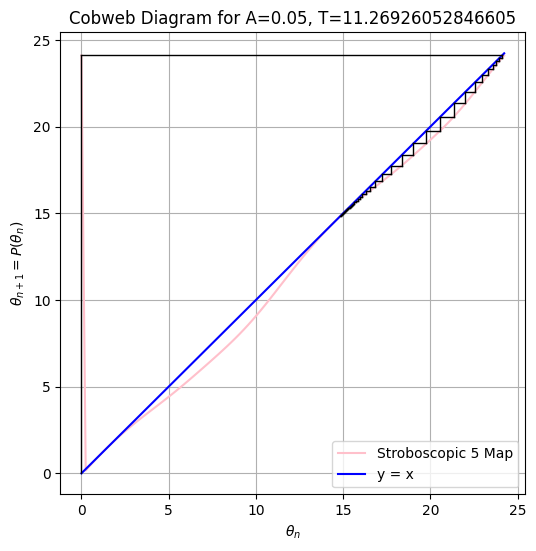

In [14]:
# COBWEB plot to analyze the boundaries of the Arnold tongue.
def cobweb_plot_squared(x0, T, A, num_steps):
    # Prepare the figure
    plt.figure(figsize=(6, 6))

    # Define the range for x values
    x = np.linspace(0, Period, 100)
    y = [poincare_map_2(val,A,T, interp_orbit_iPRC) for val in x]  # Map values for y-axis
   

    # Plot y = f(x) and y = x
    plt.plot(x, y, label='Stroboscopic 5 Map', color='pink')
    
    plt.plot(x, x, label='y = x', color='blue')

     # Plot the cobweb diagram
    x_n = x0
    for _ in range(num_steps):
        x_next = poincare_map_2(x_n,A,T, interp_orbit_iPRC)  # compute the following point

        # Vertical line (x_n, f(x_n))
        plt.plot([x_n, x_n], [x_n, x_next], color='black', lw=1)

        # Horizontal line (f(x_n), x_{n+1})
        plt.plot([x_n, x_next], [x_next, x_next], color='black', lw=1)

        # Update to the next point
        x_n = x_next

    # Add plot details
    plt.title(f'Cobweb Diagram for A={A}, T={T}')
    plt.xlabel(r'$\theta_n$')
    plt.ylabel(r'$\theta_{n+1} = P(\theta_n)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call to the function with initial parameters
cobweb_plot_squared(0, 0.465*Period, 0.05, 100)


In [16]:
# The following code helps us find a point on the boundary of the Arnold tongue.

import numpy as np
from scipy.optimize import fsolve
import numdifftools as nd

def derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: poincare_map_2(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T 
T = 0.465*Period

# Initial guess for [theta, A]
initial_guess = [14.83, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")


Solution found:
theta = 14.508587304588758
A = 0.049777848390929746

Verification of conditions:
Condition 1 (Phi_T - theta): -1.1457501614131615e-12
Condition 2 (dPhi/dT - 1): 1.234568003383174e-13

Both conditions are satisfied within the specified tolerance.


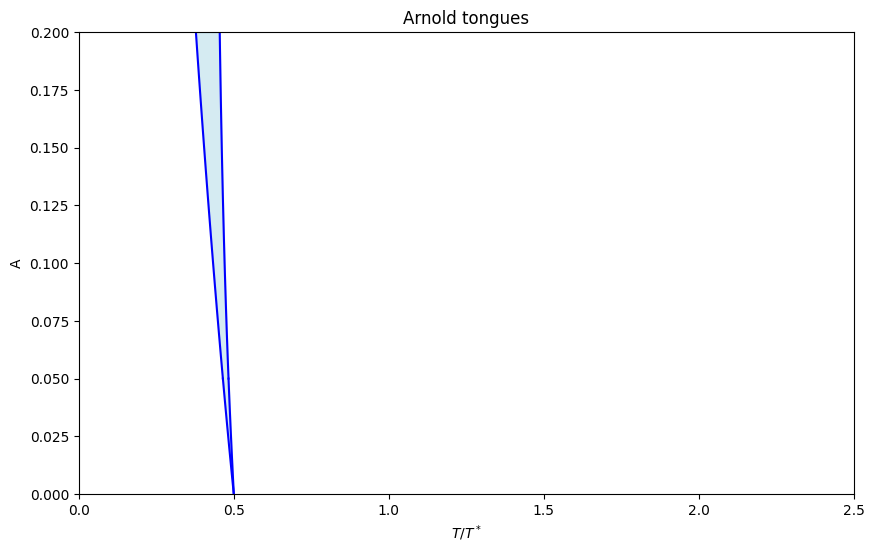

In [17]:
# The following code calculates the 1:2 Arnold tongue for pulsatile inputs. 
#The explanation of the method can be found in the appendix of the written thesis.


num_iterations_up_r = 16  # Number of desired iterations

T_values_right = []
A_values_right = []


A = 0.05

# Initial conditions
initial_guess = [8.8525, 0.49*Period]


def phase_conditions_root(vars):
    theta, T = vars  # Unpack variables

    Phi_T = poincare_map_2(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    dPhi_dtheta = derivative_stroboscopic_map_analytic(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])


for i in range(num_iterations_up_r):
   
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    theta_solution, T_solution = solution.x

    T_values_right.append(T_solution / Period) 
    A_values_right.append(A)  
    
    #print(T/Period)
 
    A += 0.01 
    initial_guess = [theta_solution, T_solution]  

num_iterations_down_r = 6
A = 0.05

initial_guess = [8.8525, 0.49*Period]


for i in range(num_iterations_down_r):
    
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    theta_solution, T_solution = solution.x

    T_values_right.append(T_solution / Period) 
    A_values_right.append(A)    
    #print(T/Period)
    
    A -= 0.01  
    initial_guess = [theta_solution, T_solution]  

num_iterations_up_left = 16  


T_values = []
A_values = []


A = 0.05


initial_guess = [14.506, 0.465*Period]


for i in range(num_iterations_up_left):
   
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

   
    theta_solution, T_solution = solution.x

   
    T_values.append(T_solution / Period)  
    A_values.append(A)   

    #print(T/Period)
   
    A += 0.01  #
    initial_guess = [theta_solution, T_solution]  
    
num_iterations_down_left = 6
A = 0.05

initial_guess = [14.506, 0.465*Period]


for i in range(num_iterations_down_left):
    
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

   
    theta_solution, T_solution = solution.x

   
    T_values.append(T_solution / Period) 
    A_values.append(A)   

    #print(T/Period)
    
    A -= 0.01  
    initial_guess = [theta_solution, T_solution] 



A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points as a function of A.

interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)



# Graph the curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:],color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:],color='blue')

# Fill the area between the two interpolated curves.
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)


plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()


# Saving data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp_1_2_inf.npy", T_values_left_interp)
np.save("T_values_right_interp_1_2_inf.npy", T_values_right_interp)


### Computation of Arnold tongues for $\kappa \neq \infty$

In [17]:
import numpy as np
from scipy.optimize import fsolve

T = 1.94*Period
A = 0.05

stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)


def fixed_point_condition(theta):
    return stroboscopic_map_theta(theta) - theta


initial_theta = 10  

theta_solution = fsolve(fixed_point_condition, initial_theta)[0]

print("Valor de theta encontrado:", theta_solution)

verificacion = fixed_point_condition(theta_solution)
print("Verificación (debe ser cercano a 0):", verificacion)


Valor de theta encontrado: 10.894163636667939
Verificación (debe ser cercano a 0): 2.970246271161159e-11


In [18]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta = lambda theta: stroboscopic_map(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta)(theta)
    return dPhi_dtheta

# Set T to be 95% of the period
T = 1.94*Period

# Initial guess for [theta, A]
initial_guess = [10.89, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")


Solution found:
theta = 13.218778179099425
A = 0.061037296987694334

Verification of conditions:
Condition 1 (Phi_T - theta): -5.097025024269897e-10
Condition 2 (dPhi/dT - 1): 6.56226184503339e-11

Both conditions are satisfied within the specified tolerance.


1.0020631344835156
1.0030631344835157
1.0040631344835156
1.0050631344835155
1.0060631344835156
1.0070631344835155
1.0080631344835156
1.0090631344835155
1.0100631344835154
1.0110631344835155
1.0120631344835154
1.0130631344835153
1.0140631344835154
1.0150631344835153
1.0160631344835154
1.0170631344835153
1.0180631344835152
1.0190631344835153
1.0200631344835152
1.021063134483515
1.0020631344835156
1.0010631344835157
1.0000631344835158
0.9990631344835158
0.9980631344835158
0.95
0.945
0.94
0.9349999999999999
0.9299999999999999
0.9249999999999999
0.9199999999999999
0.9149999999999999
0.9099999999999999
0.9049999999999999
0.8999999999999999
0.8949999999999999
0.8899999999999999
0.8849999999999999
0.8799999999999999
0.8749999999999999
0.8699999999999999
0.8649999999999999
0.8599999999999999
0.8549999999999999
0.8499999999999999
0.8449999999999999
0.8399999999999999
0.8349999999999999
0.8299999999999998
0.8249999999999998
0.8199999999999998
0.815
0.8099999999999999
0.8049999999999999
0.79999999

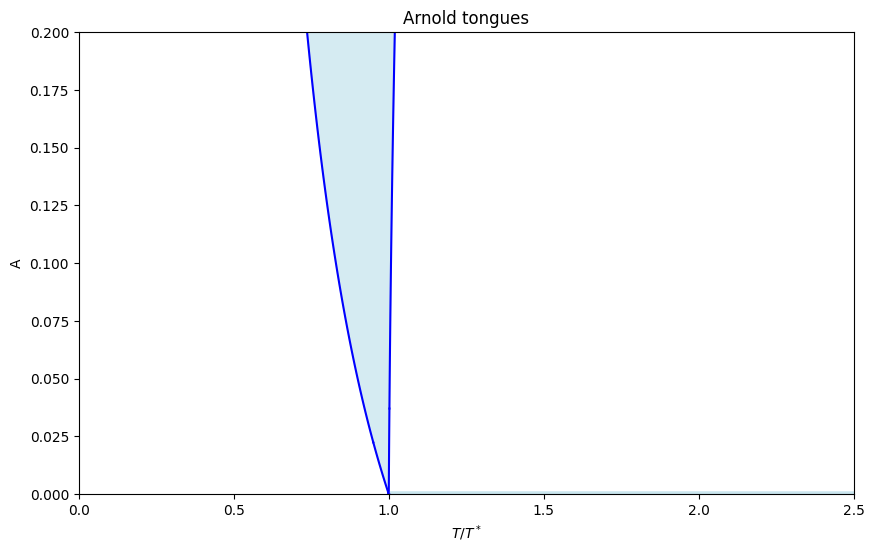

In [20]:
#COMPUTATION OF THE 1:1 ARNOLD TONGUE
# Set the increment h
h = 0.001  # The desired step size
num_iterations_up_r = 20  # Number of iterations desired

# Initialize lists to store results
T_values_right = []
A_values_right = []

# Initialize T to 95% of the Period
T = Period + 0.05

# Initial conditions
initial_guess = [12.31, 0.05]

#Initial conditions for k=20
#initial_guess = [9.61, 0.05] T = Period + 0.1
#initial_guess = [12.31, 0.05] T = Period + 0.1
#initial_guess = [2.97, 0.05] T = 0.88 * Period

# Function to find roots
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_up_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in lists
    T_values_right.append(T / Period)  # Save normalized T
    A_values_right.append(A_solution)  # Save A

    print(T / Period)
    # Prepare new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new initial point

num_iterations_down_r = 5
T = Period + 0.05
# Initial conditions
initial_guess = [12.31, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down_r):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in lists
    T_values_right.append(T / Period)  # Save normalized T
    A_values_right.append(A_solution)  # Save A

    print(T / Period)
    # Prepare new T
    T -= h * Period  # Decrement T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new initial point


# Set the increment h
h = 0.005  # The desired step size
num_iterations_up_left = 50  # Number of iterations desired

# Initialize lists to store results
T_values = []
A_values = []

# Initialize T to 95% of the Period
T = 0.95 * Period

# Initial conditions
initial_guess = [7.16, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_up_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in lists
    T_values.append(T / Period)  # Save normalized T
    A_values.append(A_solution)  # Save A

    print(T / Period)
    # Prepare new T
    T -= h * Period  # Decrement T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new initial point

num_iterations_down_left = 20
T = 0.95 * Period
# Initial conditions
initial_guess = [7.16, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract results
    theta_solution, A_solution = solution.x

    # Store values in lists
    T_values.append(T / Period)  # Save normalized T
    A_values.append(A_solution)  # Save A

    print(T / Period)
    # Prepare new T
    T += h * Period  # Increment T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new initial point


# Create a set of common points for the y-axis (A), e.g., from 0 to 0.2
A_common = np.linspace(0, 0.2, 200)

# Interpolate both curves for these common points as a function of A
interp_left = interp1d(A_values, T_values, bounds_error=False, fill_value="extrapolate")
interp_right = interp1d(A_values_right, T_values_right, bounds_error=False, fill_value="extrapolate")

# Evaluate both interpolations at the common points of A
T_values_left_interp = interp_left(A_common)
T_values_right_interp = interp_right(A_common)


# Plot the original curves
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_right[0:num_iterations_up_r], A_values_right[0:num_iterations_up_r], color='blue')
plt.plot(T_values_right[num_iterations_up_r:], A_values_right[num_iterations_up_r:], color='blue')
plt.plot(T_values[0:num_iterations_up_left], A_values[0:num_iterations_up_left], color='blue')
plt.plot(T_values[num_iterations_up_left:], A_values[num_iterations_up_left:], color='blue')

# Fill the area between the two interpolated curves
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='lightblue', alpha=0.5)


# Labels and additional settings
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()


# Save data to .npy files
np.save("A_common.npy", A_common)
np.save("T_values_left_interp.npy", T_values_left_interp)
np.save("T_values_right_interp.npy", T_values_right_interp)


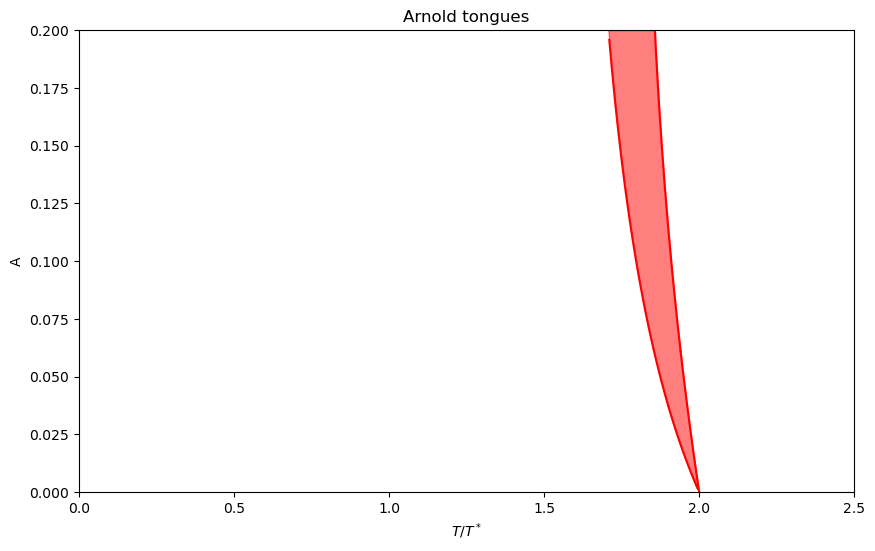

In [28]:
#COMPUTATION OF THE 2:1 ARNOLD TONGUE
# Set the increment h
h = 0.01  # Desired step size
num_iterations_right = 15  # Number of iterations desired

# Initialize lists to store the results
T_values_right_2 = []
A_values_right_2 = []

# Initialize T to 95% of the Period
T = 1.94 * Period

# Initial conditions
initial_guess = [10.89, 0.05]

#Initial conditions for k=20
#initial_guess = [10.82, 0.05] T=2.02*Period
#initial_guess = [3.37, 0.05] T=1.8*Period

# Function to find roots
def phase_conditions_root(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_right):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_right_2.append(T / Period)  # Save normalized T
    A_values_right_2.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

h = 0.01  # Desired step size
num_iterations_down = 9  # Number of iterations desired

# Initialize T to 95% of the Period
T = 1.94 * Period

# Initial conditions
initial_guess = [10.89, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_right_2.append(T / Period)  # Save normalized T
    A_values_right_2.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point


# Set the increment h
h = 0.01  # Desired step size
num_iterations_left = 20  # Number of iterations desired

# Initialize lists to store the results
T_values_left_2 = []
A_values_left_2 = []

# Initialize T to 95% of the Period
T = 1.9 * Period

# Initial conditions
initial_guess = [6.92, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_left_2.append(T / Period)  # Save normalized T
    A_values_left_2.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

h = 0.005  # Desired step size
num_iterations_down = 20  # Number of iterations desired

# Initialize T to 95% of the Period
T = 1.9 * Period

# Initial conditions
initial_guess = [6.92, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_left_2.append(T / Period)  # Save normalized T
    A_values_left_2.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

# Interpolating data for Arnold tongue plots
A_common = np.linspace(0, 0.2, 200)
interp_left_2 = interp1d(A_values_left_2, T_values_left_2, bounds_error=False, fill_value="extrapolate")
interp_right_2 = interp1d(A_values_right_2, T_values_right_2, bounds_error=False, fill_value="extrapolate")
T_values_left_interp_2 = interp_left_2(A_common)
T_values_right_interp_2 = interp_right_2(A_common)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_left_2[0:num_iterations_left], A_values_left_2[0:num_iterations_left], color='red')
plt.plot(T_values_left_2[num_iterations_left:], A_values_left_2[num_iterations_left:], color='red')
plt.plot(T_values_right_2[0:num_iterations_right], A_values_right_2[0:num_iterations_right], color='red')
plt.plot(T_values_right_2[num_iterations_right:], A_values_right_2[num_iterations_right:], color='red')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='red', alpha=0.5)

plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

np.save("T_values_left_interp_2.npy", T_values_left_interp_2)
np.save("T_values_right_interp_2.npy", T_values_right_interp_2)


In [19]:
# Define the function for P^2(theta) in order to find the 1:2 Arnold tongue
def stroboscopic_map_squared(x, A, T,interp_orbit_iPRC):
    # Apply stroboscopic_map twice
    first_application = stroboscopic_map(x, A, T, interp_orbit_iPRC)
    second_application = stroboscopic_map(first_application, A, T, interp_orbit_iPRC)
    return second_application

In [20]:
import numpy as np
from scipy.optimize import fsolve

def derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC):
    stroboscopic_map_theta_squared = lambda theta: stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)
    dPhi_dtheta = nd.Derivative(stroboscopic_map_theta_squared)(theta)
    return dPhi_dtheta


T = 0.48*Period

# Initial guess for [theta, A]
initial_guess = [6.657, 0.05]

# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_squared(vars):
    theta, A = vars  # Unpack variables

    # Evaluar el mapa estroboscópico
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Use fsolve to find a root, starting from the initial guess
solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

# Extract the result
theta_solution, A_solution = solution.x

# Check conditions by evaluating phase_conditions_root at the solution
cond1, cond2 = phase_conditions_root_squared([theta_solution, A_solution])

# Output the solution and the values of the conditions
print("Solution found:")
print(f"theta = {theta_solution}")
print(f"A = {A_solution}")
print("\nVerification of conditions:")
print(f"Condition 1 (Phi_T - theta): {cond1}")
print(f"Condition 2 (dPhi/dT - 1): {cond2}")

# Check if both conditions are close to zero
tolerance = 1e-6
if abs(cond1) < tolerance and abs(cond2) < tolerance:
    print("\nBoth conditions are satisfied within the specified tolerance.")
else:
    print("\nWarning: One or both conditions are not satisfied within the specified tolerance.")

Solution found:
theta = 7.761854980247366
A = 0.05221692685299066

Verification of conditions:
Condition 1 (Phi_T - theta): 3.15432124864401e-10
Condition 2 (dPhi/dT - 1): -1.5465895231159266e-10

Both conditions are satisfied within the specified tolerance.


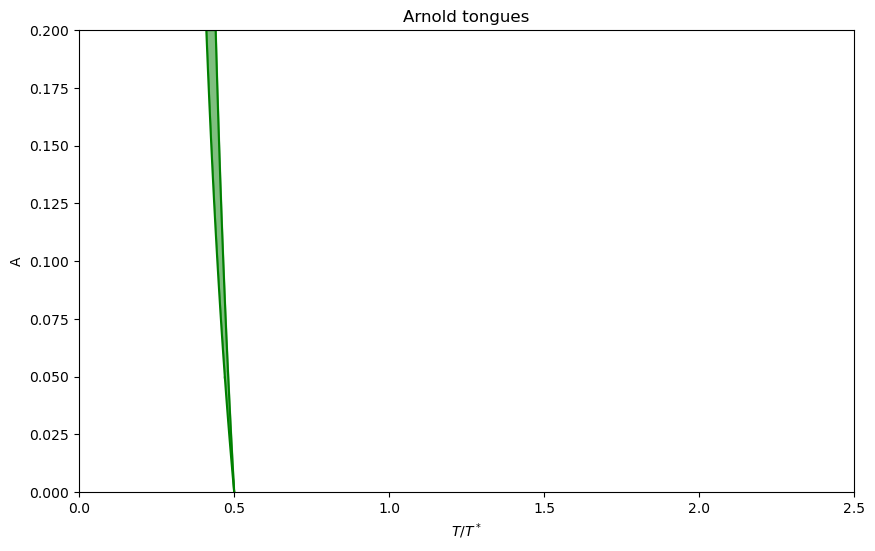

In [23]:
#COMPUTATION OF THE 1:2 ARNOLD TONGUE
# Set the increment h
h = 0.005  # Desired step size
num_iterations_right = 20  # Number of iterations desired

# Initialize lists to store the results
T_values_right_1 = []
A_values_right_1 = []

# Initialize T to 95% of the Period
T = 0.47 * Period

# Initial conditions
initial_guess = [15.5, 0.05]

#Initial conditions for k=20
#initial_guess = [14.57, 0.05] T=0.468*Period
#initial_guess = [6.02, 0.05] T=0.48*Period


# Define the function to find roots for [theta, A] given a fixed T
def phase_conditions_root_squared(vars):
    theta, A = vars  # Unpack variables

    # Evaluate the stroboscopic map
    Phi_T = stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 1: Phi_T - theta = 0
    cond1 = Phi_T - theta

    # Derivative with respect to theta
    dPhi_dtheta = derivative_stroboscopic_map_squared(theta, A, T, interp_orbit_iPRC)

    # Condition 2: dPhi/dT - 1 = 0
    cond2 = dPhi_dtheta - 1

    return np.array([cond1, cond2])

# Loop to iterate and find new points
for i in range(num_iterations_right):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_right_1.append(T / Period)  # Save normalized T
    A_values_right_1.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

h = 0.005  # Desired step size
num_iterations_down = 10  # Number of iterations desired

# Initialize T to 95% of the Period
T = 0.47 * Period

# Initial conditions
initial_guess = [15.5, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_right_1.append(T / Period)  # Save normalized T
    A_values_right_1.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point


# Set the increment h
h = 0.005  # Desired step size
num_iterations_left = 20  # Number of iterations desired

# Initialize lists to store the results
T_values_left_1 = []
A_values_left_1 = []

# Initialize T to 95% of the Period
T = 0.48 * Period

# Initial conditions
initial_guess = [6.657, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_left):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_left_1.append(T / Period)  # Save normalized T
    A_values_left_1.append(A_solution)  # Save A

    # Prepare the new T
    T -= h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

h = 0.005  # Desired step size
num_iterations_down = 15  # Number of iterations desired

# Initialize T to 95% of the Period
T = 0.48 * Period

# Initial conditions
initial_guess = [6.657, 0.05]

# Loop to iterate and find new points
for i in range(num_iterations_down):
    # Use fsolve to find a root
    solution = root(phase_conditions_root_squared, initial_guess, method='hybr', tol=1e-8)

    # Extract the results
    theta_solution, A_solution = solution.x

    # Store values in the lists
    T_values_left_1.append(T / Period)  # Save normalized T
    A_values_left_1.append(A_solution)  # Save A

    # Prepare the new T
    T += h * Period  # Decrease T
    initial_guess = [theta_solution, A_solution]  # Use the solution found as the new starting point

# Interpolating data for Arnold tongue plots
A_common = np.linspace(0, 0.2, 200)
interp_left_1 = interp1d(A_values_left_1, T_values_left_1, bounds_error=False, fill_value="extrapolate")
interp_right_1 = interp1d(A_values_right_1, T_values_right_1, bounds_error=False, fill_value="extrapolate")
T_values_left_interp_1 = interp_left_1(A_common)
T_values_right_interp_1 = interp_right_1(A_common)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.plot(T_values_left_1[0:num_iterations_left], A_values_left_1[0:num_iterations_left], color='green')
plt.plot(T_values_left_1[num_iterations_left:], A_values_left_1[num_iterations_left:], color='green')
plt.plot(T_values_right_1[0:num_iterations_right], A_values_right_1[0:num_iterations_right], color='green')
plt.plot(T_values_right_1[num_iterations_right:], A_values_right_1[num_iterations_right:], color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='green', alpha=0.5)

plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.grid(False)
plt.show()

np.save("T_values_left_interp_1.npy", T_values_left_interp_1)
np.save("T_values_right_interp_1.npy", T_values_right_interp_1)


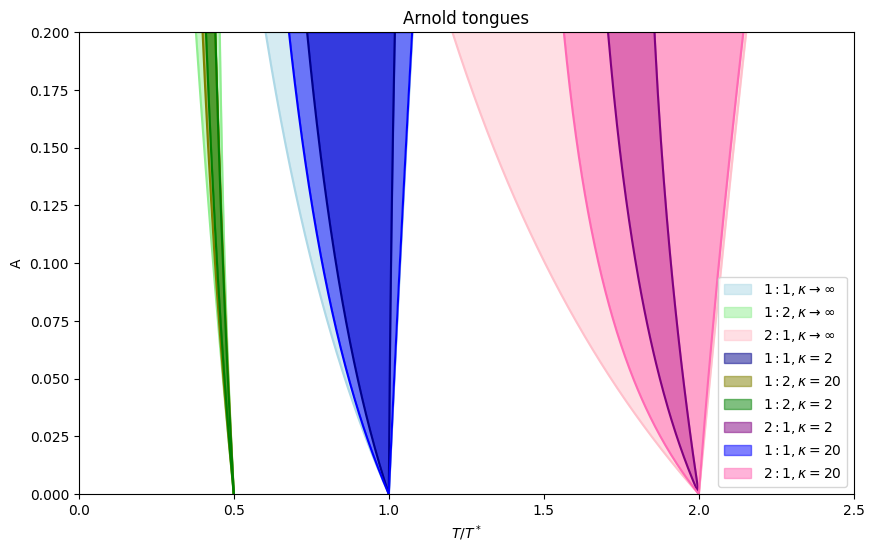

In [18]:
#FINALS ARNOLD TONGUES: k=2, k=20, k=infinity

import numpy as np

# Loading data back
A_common = np.load("A_common.npy")
T_values_left_interp = np.load("T_values_left_interp.npy")
T_values_right_interp = np.load("T_values_right_interp.npy")
T_values_left_interp_1 = np.load("T_values_left_interp_1.npy")
T_values_right_interp_1 = np.load("T_values_right_interp_1.npy")
T_values_left_interp_2 = np.load("T_values_left_interp_2.npy")
T_values_right_interp_2 = np.load("T_values_right_interp_2.npy")
T_values_left_interp_k20 = np.load("T_values_left_interp_k20.npy")
T_values_right_interp_k20 = np.load("T_values_right_interp_k20.npy")
T_values_left_interp_1_k20 = np.load("T_values_left_interp_1_k20.npy")
T_values_right_interp_1_k20 = np.load("T_values_right_interp_1_k20.npy")
T_values_left_interp_2_k20 = np.load("T_values_left_interp_2_k20.npy")
T_values_right_interp_2_k20 = np.load("T_values_right_interp_2_k20.npy")
T_values_left_inf = np.load("T_values_left_interp_1_2_inf.npy")
T_values_right_inf = np.load("T_values_right_interp_1_2_inf.npy")

time_points = np.linspace(0, Period, 1000)
interp_values = interp_orbit_iPRC(time_points)  # Evaluar interp_orbit_iPRC

# Extracción y cálculo de componentes de Z
Z_values = interp_values[1] + interp_values[5]
Zmax = np.max(Z_values)
Zmin = np.min(Z_values)

# Definir A y calcular T/T* para diferentes escalas
AA_values = np.linspace(0, 0.2, 500)
T_over_Tstar_max = 1 + AA_values * Zmax
T_over_Tstar_min = 1 + AA_values * Zmin

T_over_Tstar_max_3 = (1/2) * (1 + AA_values * Zmax)
T_over_Tstar_min_3 = (1/2) * (1 + AA_values * Zmin)


# Combinación y gráfico
plt.figure(figsize=(10, 6))

# Relleno y contornos del primer conjunto de curvas
plt.fill_betweenx(AA_values, 1/T_over_Tstar_min, 1/T_over_Tstar_max, color='lightblue', alpha=0.5,label=r'$1:1, \kappa \rightarrow \infty$')
plt.plot(1/T_over_Tstar_max, AA_values, color='lightblue')
plt.plot(1/T_over_Tstar_min, AA_values, color='lightblue')
plt.fill_betweenx(A_common,T_values_right_inf , T_values_left_inf, color='lightgreen', alpha=0.5, label=r'$1:2, \kappa \rightarrow \infty$')
plt.plot(T_values_left_inf, A_common, color='lightgreen')
plt.plot(T_values_right_inf, A_common, color='lightgreen')
plt.fill_betweenx(AA_values, 1/T_over_Tstar_min_3, 1/T_over_Tstar_max_3, color='pink', alpha=0.5,label=r'$2:1, \kappa \rightarrow \infty$')
plt.plot(1/T_over_Tstar_max_3, AA_values, color='pink')
plt.plot(1/T_over_Tstar_min_3, AA_values, color='pink')


# Gráfico de Arnold tongues y relleno entre curvas interpoladas 1:1
plt.plot(T_values_left_interp, A_common, color='darkblue')
plt.plot(T_values_right_interp[2:], A_common[2:], color='darkblue')
plt.fill_betweenx(A_common[2:], T_values_left_interp[2:], T_values_right_interp[2:], color='darkblue',alpha=0.5,label=r'$1:1, \kappa=2$')

#Plot 1:2

plt.plot(T_values_left_interp_1_k20, A_common, color='olive')
plt.plot(T_values_right_interp_1_k20, A_common, color='olive')
plt.fill_betweenx(A_common, T_values_left_interp_1_k20, T_values_right_interp_1_k20, color='olive',alpha=0.5,label=r'$1:2, \kappa=20$')




#Plot 1:2

plt.plot(T_values_left_interp_1, A_common, color='green')
plt.plot(T_values_right_interp_1, A_common, color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='green',alpha=0.5,label=r'$1:2, \kappa=2$')


#Plot 2:1

plt.plot(T_values_left_interp_2, A_common, color='purple')
plt.plot(T_values_right_interp_2, A_common, color='purple')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='purple',alpha=0.5,label=r'$2:1, \kappa=2$')


# Gráfico de Arnold tongues y relleno entre curvas interpoladas 1:1
plt.plot(T_values_left_interp_k20, A_common, color='blue')
plt.plot(T_values_right_interp_k20, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp_k20, T_values_right_interp_k20, color='blue',alpha=0.5,label=r'$1:1, \kappa=20$')



#Plot 2:1

plt.plot(T_values_left_interp_2_k20, A_common, color='hotpink')
plt.plot(T_values_right_interp_2_k20, A_common, color='hotpink')
plt.fill_betweenx(A_common, T_values_left_interp_2_k20, T_values_right_interp_2_k20, color='hotpink',alpha=0.5,label=r'$2:1, \kappa=20$')
# Configuración final del gráfico
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()



### CTC measures

In [ ]:
#Pre-computations for Delta tau
# Solve the ODE system
# Time span for integration
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")
t = np.linspace(0, 15*Period, 20000)
T=Period
A=0.01
# Solve the system of equations
atol = 1e-17
rtol = 1e-13
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)

# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)


t= np.linspace(0, 40 * T, 100000) 
sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
P_2=sol[-1]
t= np.linspace(0, 2*T, 10000)
sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
# Extract r_i(t) = x[5] and p(t)
r_i = sol[:, 4]
p_t = p(t, T)
        
# Ignore the initial transient by selecting only the times after transient_time
t_after_transient = t[(t <= T)]
#r_i_after_transient = r_i[t >= transient_time]
p_after_transient = p_t[(t <= T)]
# Find the time t_p of the maximum of p after the transient
t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
# Limit search for r_i to one period T after t_p
t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
# Find the maximum of r_i within this period
t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
# Calculate Delta_tau
Delta_tau = (t_inh - t_p) / T


# Output the result
print(f"t_inh (time of max r_i after transient): {t_inh}")
print(f"t_p (time of max p after transient): {t_p}")
print(f"Delta_tau: {Delta_tau}")


# Optional: Plotting r_i and p to visualize
plt.figure(figsize=(12, 6))
plt.plot(t, r_i, label=r'$r_i(t)$ (inhibitory rate)')
plt.plot(t, A*p_t, label=r'$p(t)$ (external input)', linestyle='--')
plt.axvline(t_inh, color='red', linestyle=':', label=r'$t_{\text{inh}}$ (max $r_i$ after transient)')
plt.axvline(t_p, color='blue', linestyle=':', label=r'$t_p$ (max $p$ after transient)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Inhibitory Neuron Activity $r_i(t)$ and External Input $p(t)$ after Transient')
plt.legend()
plt.show()

In [ ]:
#Computation of Delta tau
from scipy.interpolate import interp1d
t = np.linspace(0, 30 * Period, 100000)  # Adjust time range and resolution as needed
A_values= np.linspace(0.01,0.2,20)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
    T_left = interp_left(A)*Period
    T_right = interp_right(A)*Period
    
    # Generate equidistant values of T within bounds
    T_values = np.linspace(T_left+0.001*Period, T_right, 120)
    
    
    # Store Delta_tau values for current A
    delta_tau_values = []
    T_ratio_values = []
    
    T_ratio_plus = []     # T_ratio delta_tau > 0.6
    Delta_tau_plus = []   # delta_tau > 0.6
    T_ratio_minus = []    # T_ratio delta_tau <= 0.6
    Delta_tau_minus = []  # delta_tau <= 0.6

    for T in T_values:
        # Simulate the system with current A and T
        t= np.linspace(0, 60 * T, 1000000) 
        sol = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol[-1]
        t= np.linspace(0, 2*T, 10000)
        sol=odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        
        # Extract r_i(t) = x[5] and p(t)
        r_i = sol[:, 4]
        p_t = p(t, T)
        
        # Ignore the initial transient by selecting only the times after transient_time
        t_after_transient = t[(t <= T)]
        #r_i_after_transient = r_i[t >= transient_time]
        p_after_transient = p_t[(t <= T)]
        
        # Find the time t_p of the maximum of p after the transient
        t_p_index = np.argmax(p_after_transient)  # Index of max p after transient
        t_p = t_after_transient[t_p_index]        # Time at which p reaches maximum
        
        
        # Limit search for r_i to one period T after t_p
        t_within_one_period = t[(t>=t_p)&(t<t_p+T)]
        r_i_within_one_period = r_i[(t>=t_p)&(t<t_p+T)]
        
        # Find the maximum of r_i within this period
        t_inh_index = np.argmax(r_i_within_one_period)  # Index of max r_i within one period after t_p
        t_inh = t_within_one_period[t_inh_index]        # Time at which r_i reaches max within one period after t_p
        
        # Calculate Delta_tau
        Delta_tau = (t_inh - t_p) / T
        T_ratio = T / Period
        
        # Store values for plotting
        delta_tau_values.append(Delta_tau)
        T_ratio_values.append(T_ratio)
        

    
    for delta_tau, T_ratio in zip(delta_tau_values, T_ratio_values):
        if delta_tau > 0.6:
            Delta_tau_plus.append(delta_tau)
            T_ratio_plus.append(T_ratio)
        else:
            Delta_tau_minus.append(delta_tau)
            T_ratio_minus.append(T_ratio)

    # Plot Delta_tau vs T / Period for the current A
    plt.plot(T_ratio_plus, Delta_tau_plus, label=f'A={A:.2f}', color=colors[i])
    plt.plot(T_ratio_minus, Delta_tau_minus, color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\tau}$')
plt.legend(loc='upper left')
plt.title(r'$\Delta_{\tau}$ vs $T / T^*$ for Different Values of A')
plt.grid(True)
plt.show()

In [ ]:
#Computation of Delta Alpha Bar
import numpy as np
from scipy.integrate import odeint, trapezoid
import matplotlib.pyplot as plt
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")

t = np.linspace(0, 40 * Period,1000000)
sol_0 = odeint(neural_network, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
P_2=sol_0[-1]
t = np.linspace(0,  Period,10000)
sol_0 = odeint(neural_network, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary
# Compute R_bar_0 (mean over one period T_star)
R_bar_0 = trapezoid(r_e_0, dx=Period/len(t)) / Period
# Setup parameters for plotting
A_values = np.linspace(0.01, 0.2, 20)  # Range of perturbation values
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

plt.figure(figsize=(12, 8))

for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
    T_left = interp_left(A) * Period
    T_right = interp_right(A) * Period
    T_values = np.linspace(T_left+0.001*Period, T_right, 150)

    delta_bar_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        # Solve system with perturbation A
        t = np.linspace(0, 40 * T,1000000)
        sol_A = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        P_2=sol_A[-1]
        t = np.linspace(0, T,10000)
        sol_A = odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_bar_A = trapezoid(r_e_A, dx=T/len(t)) / T
        #print(R_bar_A)
        # Compute Delta_bar_alpha
        Delta_bar_alpha = R_bar_A / R_bar_0
        T_ratio = T / Period

        # Store values for plotting
        delta_bar_alpha_values.append(Delta_bar_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_bar_alpha_values, label=f'A={A:.2f}', color=colors[i])

# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\bar{\alpha}}$')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
#Computation of Delta Alpha

t = np.linspace(0, 60 * Period, 1000000)  # Adjust time range and resolution as needed

sol_0 = odeint(neural_network, P_1, t, args =(0,1,), atol=atol, rtol=rtol)
t = np.linspace(0, Period, 100000)  # Adjust time range and resolution as needed
P_2=sol_0[-1]
sol_0 = odeint(neural_network, P_2, t, args =(0,1,), atol=atol, rtol=rtol)
r_e_0 = sol_0[:,0]  # Assuming r_e is the first component of x; update as necessary

# Compute R_0 
R_0 = np.max(r_e_0)

A_values= np.linspace(0.01,0.2,20)
# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A
for i, A in enumerate(A_values):
    # Interpolate bounds for T based on A
     # Interpolate bounds for T based on A
    T_left = interp_left(A) * Period
    T_right = interp_right(A) * Period
    T_values = np.linspace(T_left+0.001*Period, T_right, 120)

    delta_alpha_values = []
    T_ratio_values = []

    for T in T_values:
        # Solve system with perturbation A
        t=np.linspace(0, 60 * T, 1000000)
        sol_A = odeint(neural_network, P_1, t, args =(A,T,), atol=atol, rtol=rtol)
        #plt.plot(t,sol_A[:,0],label=f'{T}')
        P_2=sol_A[-1]
        t=np.linspace(0, T, 100000)
        sol_A = odeint(neural_network, P_2, t, args =(A,T,), atol=atol, rtol=rtol)
        r_e_A=sol_A[:,0]
        R_A = np.max(r_e_A)
        
        
        # Compute Delta_bar_alpha
        Delta_alpha = R_A / R_0
        T_ratio = T / Period

        # Store values for plotting
        delta_alpha_values.append(Delta_alpha)
        T_ratio_values.append(T_ratio)

    plt.plot(T_ratio_values, delta_alpha_values, label=f'A={A:.2f}', color=colors[i])
    
# Label and show plot
plt.xlabel(r'$T / T^*$')
plt.ylabel(r'$\Delta_{\alpha}$')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#Computation of Delta sigma
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
interp_left=interp1d(A_common, T_values_left_interp, bounds_error=False, fill_value="extrapolate")
interp_right=interp1d(A_common, T_values_right_interp, bounds_error=False, fill_value="extrapolate")

# Define time array and solve for unperturbed solution
t = np.linspace(0,40 * Period, 100000)  # Adjust time range and resolution as needed
sol_0 = odeint(neural_network, P_1, t, args=(0, 1), atol=atol, rtol=rtol)
P_2=sol_0[-1]
t = np.linspace(0, 2*Period, 10000) 
sol_0 = odeint(neural_network, P_2, t, args=(0, 1), atol=atol, rtol=rtol)
r_e_0 = sol_0[:, 0]  # Assuming r_e is the first component of x

t_min=(t<=Period)
r_e_0_min=r_e_0[t_min]
index_min = np.argmin(r_e_0_min)
t_0 = t[index_min]

# Define the range where to find t_1 and t_2 (t_0 and t_0 + T)
mask_range = (t >= t_0) & (t < t_0 + Period)
t_in_range = t[mask_range]
r_e_in_range = r_e_0[mask_range]

HW_0=find_half_width_times(r_e_in_range,t_in_range)


# Define a function to find t1 and t2 for half-width calculation
def find_half_width_times(r_e, t_interval):
    # Calculate the threshold as half of max + min of r_e in the interval
    r_e_max = np.max(r_e)
    r_e_min = np.min(r_e)
    threshold = 0.5 * (r_e_max + r_e_min)
    
    # Find times where r_e crosses the threshold
    indices_above = np.where(r_e >= threshold)[0]
    
    # Ensure at least two times are found
    if len(indices_above) >= 2:
        t1 = t_interval[indices_above[0]]
        t2 = t_interval[indices_above[-1]]
        return 0.5 * (t2 - t1)
    else:
        return None

A_values = np.linspace(0.01, 0.2, 20)  # Define your A values

# Prepare plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(A_values)))

# Loop over each A value to compute and plot Delta_sigma
for i, A in enumerate(A_values):
    T_left = interp_left(A) * Period
    T_right = interp_right(A) * Period
    T_values = np.linspace(T_left+0.001*Period, T_right, 100)

    delta_sigma_values = []
    T_ratio_values = []

    for T in T_values:
        # Solve system with perturbation A
        t = np.linspace(0, 80 * T, 500000)  # Adjust time range and resolution as needed
        sol_A = odeint(neural_network, P_1, t, args=(A, T), atol=atol, rtol=rtol)
        P_2=sol_A[-1]
        t = np.linspace(0, 2*Period, 100000) 
        sol_A = odeint(neural_network, P_2, t, args=(A, T), atol=atol, rtol=rtol)
        r_e_A = sol_A[:, 0]  # Assuming r_e is the first component of x
        # Encuentra el índice del mínimo de r_e para localizar t_0
        t_min=(t<=T)
        r_e_A_min=r_e_A[t_min]
        index_min = np.argmin(r_e_A_min)
        t_0 = t[index_min]

        # Define el rango en el cual buscar t_1 y t_2 (es decir, entre t_0 y t_0 + T)
        mask_range = (t >= t_0) & (t < t_0 + T)
        t_in_range = t[mask_range]
        r_e_in_range = r_e_A[mask_range]
        
        HW_A=find_half_width_times(r_e_in_range,t_in_range)

        # Only proceed if HW_A was successfully computed
        if HW_A is not None and HW_0 is not None:
            Delta_sigma = (HW_A / T) / (HW_0 / Period)
            T_ratio = T / Period

            delta_sigma_values.append(Delta_sigma)
            T_ratio_values.append(T_ratio)

    # Plot Delta_omega vs T / Period for the current A
    plt.plot(T_ratio_values, delta_sigma_values, label=f'A={A:.2f}', color=colors[i])

# Label and show plot
plt.xlabel(r'$T / \text{T}^*$')
plt.ylabel(r'$\Delta_{\sigma}$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Computation of Neural System ODEs: E-I with an excitatory input and an inhibitory input

$T_2=5T^*, \kappa_2=0.5, B=-0.1$

In [22]:
# Parameters
mu = 0
k_1 = 2
k_2 = 0.5
T_2 = 5*Period

# External input function (excitatory)
def p_1(t,T):
    I0_value = sp.iv(0, k_1)  # modified Bessel function of order 0
    return T * (np.exp(k_1 * np.cos(((2 * np.pi) * (t - mu)) / T))) / (T * I0_value)
# External input function (inhibitory)
def p_2(t,T_2):
    I0_value = sp.iv(0, k_2)  # modified Bessel function of order 0
    return -T_2 * (np.exp(k_2 * np.cos(((2 * np.pi) * (t - mu)) / T_2))) / (T_2 * I0_value)


# Neural network system of ODEs
def neural_network_2(x, t,A,B,T,T_2):
    # External inputs for excitatory and inhibitory neurons
    I_e_ext = I_bar_e + tau_e * (A * p_1(t,T) + B * p_2(t,T_2))
    I_i_ext = I_bar_i + tau_i * (A * p_1(t,T) + B * p_2(t,T_2))

    # Compute the total external input to the neurons
    I_e = I_e_ext + tau_e * x[2] - tau_e * x[3]
    I_i = I_i_ext + tau_i * x[6] - tau_i * x[7]

    # System of equations (neuronal dynamics)
    dxdt = [
        (1 / tau_e) * (Delta_e / (np.pi * tau_e) + 2 * x[0] * x[1]),  # re
        (1 / tau_e) * (x[1] ** 2 + eta_e + I_e - (tau_e * np.pi * x[0]) ** 2),  # Ve
        (1 / tau_se) * (-x[2] + Jee * x[0]),  # See
        (1 / tau_si) * (-x[3] + Jei * x[4]),  # Sei
        (1 / tau_i) * (Delta_i / (np.pi * tau_i) + 2 * x[4] * x[5]),  # ri
        (1 / tau_i) * (x[5] ** 2 + eta_i + I_i - (tau_i * np.pi * x[4]) ** 2),  # Vi
        (1 / tau_se) * (-x[6] + Jie * x[0]),  # Sie
        (1 / tau_si) * (-x[7] + Jii * x[4])   # Sii
    ]
    return dxdt


# Time span for integration
t = np.linspace(0, 550, 2500)

# Solve the system of equations
atol = 1e-17
rtol = 1e-13

sol = odeint(neural_network_2, P_1, t, args =(0.2,0.2,26,5*Period,), atol=atol, rtol=rtol)

# Time threshold to avoid the initial transient (e.g., 50 time units)
time_threshold = 300  # Time threshold in the simulation

# Only consider peaks that occur after the time threshold
valid_times = t[t >= time_threshold]
valid_r_e = sol[t >= time_threshold, 0]

# Find the peaks in the valid portion of r_e
peaks, _ = signal.find_peaks(valid_r_e)
#print(t[peaks[-1]])
# Compute the period by calculating the time difference between consecutive peaks
periods = np.diff(valid_times[peaks])  # Differences between consecutive peaks

# The estimated period
estimated_period = np.mean(periods)  # Average period
print(f"Estimated period of r_e (after transient): {estimated_period} seconds")

Estimated period of r_e (after transient): 26.019296607531903 seconds


### Computation of the Vector strength

In [23]:
#INTEGRATION OF THE PHASE EQUATION
def phase_equation_2(x, t, interp_orbit_iPRC,A,B,T,T_2):
    z_t = interp_orbit_iPRC(x % Period)  # Interpolate z_t theta

    # Compute the phase equation (wrapped modulo Period)
    dtheta = 1 +  (z_t[1] + z_t[5]) * (A * p_1(t,T) + B * p_2(t,T_2))
    return dtheta

In [24]:
# Define the stroboscopic map function with updated parameters (x, A, T)
def stroboscopic_map_2(x,t_n, A,B, T,T_2,interp_orbit_iPRC):

    # Integrate the phase equation with the initial condition x
    t_phase = np.linspace(t_n, t_n+T, 1000)
    sol_theta_t = odeint(phase_equation_2, x, t_phase, args=(interp_orbit_iPRC, A,B, T,T_2), atol=atol, rtol=rtol)
    Theta_n = sol_theta_t[-1] % Period

    return Theta_n[0] #to ensure that it is an scalar



theta_n=0
Theta = []
T= 26
T_2=5*Period
#print(T/Period)
for i in range(0,50):
    theta_n=stroboscopic_map_2(theta_n,i*T,0.2,0.1,Period,5*Period, interp_orbit_iPRC)
    print(theta_n)
    Theta.append(theta_n)

6.784576114130196
10.040832194109328
12.002273302744939
13.525683678992976
14.792447744039158
16.614277372642555
18.739319129565416
20.598337367605858
21.768750584503692
22.745569721799484
0.5382470680453011
3.0208081239949998
4.813223444677718
6.152530448962867
8.57105490091908
10.730545881415509
12.516890509342069
14.015975928125144
15.280103762049208
17.090107754895726
19.203204770291663
21.027066009127367
22.11821897244451
23.09596971034749
1.0046930963251555
3.609735371434901
5.465433157923528
6.8287158976172435
9.062523572037747
11.145018840433643
12.9575049532461
14.48710125362473
15.761994311952698
17.562163358561044
19.662701943322716
21.447517656294572
22.45731200480624
23.44852837919423
1.498775302200599
4.224555501832317
6.119384037906432
7.4635664677604225
9.521645242920009
11.565861126309024
13.405911112654138
14.961651533103215
16.242569412747912
18.030932032531744
20.117710708732155
21.85995282573723


In [25]:
def vector_strength(theta_n_0,T,T_2,A,B,interp_orbit_iPRC,N):
    theta_n=theta_n_0
    Theta = []

    #print(T/Period)
    for i in range(0,N):
        theta_n=stroboscopic_map_2(theta_n,i*T,A,B,T,5*Period, interp_orbit_iPRC)
        Theta.append(theta_n)

    Theta = np.array(Theta)
    Theta = Theta * (2 * np.pi / Period)
    # Compute the complex exponentials
    exp_values = np.exp(1j * Theta)
    
    # Sum the complex exponentials
    S = np.sum(exp_values)
    
    # Compute the normalized magnitude
    norm = np.abs(S) / N

    return norm

In [26]:
vector_strength(0,Period,5*Period,0.2,0.1,interp_orbit_iPRC,1000)

np.float64(0.9924188730602777)

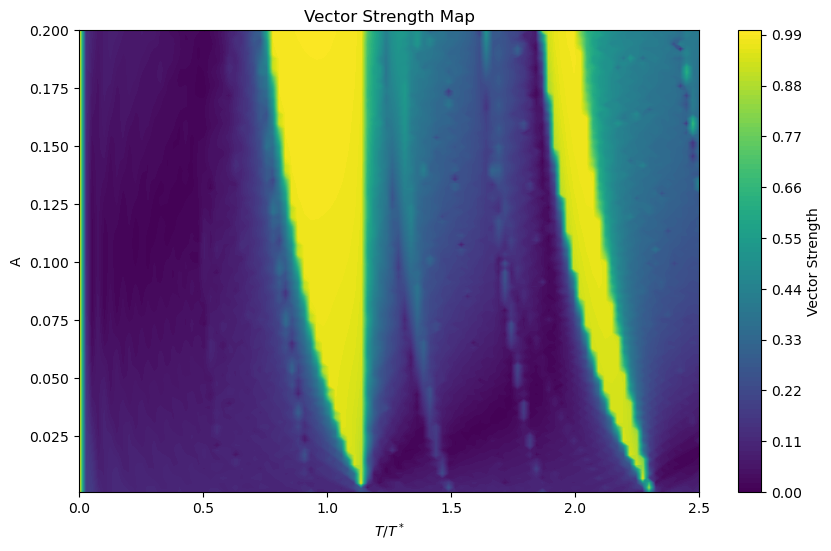

In [106]:
# Define grid parameters
A_values = np.linspace(0.001, 0.2, 100)        # 100 points between 0.001 and 0.2 for A
T_values = np.linspace(0, 2.5 * Period, 100)   # 100 points between 0 and 2.5*Period for T

# Create the meshgrid of (A, T) values
A_mesh, T_mesh = np.meshgrid(A_values, T_values)

# Initialize a matrix to store vector_strength results
vector_strength_values = np.zeros_like(A_mesh)

# Compute vector_strength for each (A, T) pair in the grid
for i in range(A_mesh.shape[0]):
    for j in range(A_mesh.shape[1]):
        A = A_mesh[i, j]
        T = T_mesh[i, j]
        
        # Call the vector_strength function (with additional parameters if needed)
        vector_strength_values[i, j] = vector_strength(theta_n_0=0, T=T, T_2=5*Period, A=A, B=0.1, 
                                                       interp_orbit_iPRC=interp_orbit_iPRC, N=100)

# Plot the results using a color scale
plt.figure(figsize=(10, 6))
plt.contourf(T_mesh / Period, A_mesh, vector_strength_values, levels=100, cmap='viridis')
plt.colorbar(label='Vector Strength')  # Color bar from 0 to 1
plt.clim(0, 1)                         # Set color scale limits between 0 and 1

# Axis labels
plt.xlabel(r'$T / T^*$')
plt.ylabel('A')
plt.title('Vector Strength Map')

plt.show()


In [ ]:
np.save("vector_strength.npy", vector_strength_values)

In [27]:
# Define the function for P^2(theta)
def stroboscopic_map_squared_2(x,t_n, A,B, T,T_2,interp_orbit_iPRC):
    # Apply stroboscopic_map twice
    first_application = stroboscopic_map_2(x,t_n, A,B, T,T_2, interp_orbit_iPRC)
    second_application = stroboscopic_map_2(first_application,t_n+T, A,B, T,T_2, interp_orbit_iPRC)
    return second_application

def vector_strength_2(theta_n_0,T,T_2,A,B,interp_orbit_iPRC,N):
    theta_n=theta_n_0
    Theta = []

    #print(T/Period)
    for i in range(0,N):
        theta_n=stroboscopic_map_squared_2(theta_n,i*2*T,A,B,T,5*Period, interp_orbit_iPRC)
        Theta.append(theta_n)

    Theta = np.array(Theta)
    Theta = Theta * (2 * np.pi / Period)
    # Compute the complex exponentials
    exp_values = np.exp(1j * Theta)
    
    # Sum the complex exponentials
    S = np.sum(exp_values)
    
    # Compute the normalized magnitude
    norm = np.abs(S) / N

    return norm

In [28]:
vector_strength_2(0,Period,5*Period,0.2,0.1,interp_orbit_iPRC,1000)

np.float64(0.9925881241424124)

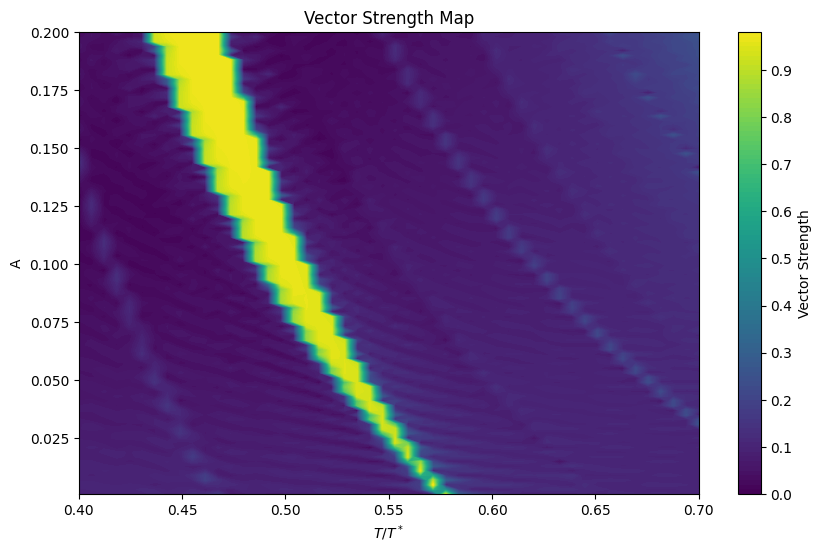

In [30]:
# Define grid parameters
A_values_2 = np.linspace(0.001, 0.2, 100)        # 100 points between 0.001 and 0.2 for A
T_values_2 = np.linspace(0.4*Period, 0.7*Period, 50)   # 50 points between 0.4*Period and 0.7*Period for T

# Create the meshgrid of (A, T) values
A_mesh_2, T_mesh_2 = np.meshgrid(A_values_2, T_values_2)

# Initialize a matrix to store vector_strength results
vector_strength_values_2 = np.zeros_like(A_mesh_2)

# Compute vector_strength for each (A, T) pair in the grid
for i in range(A_mesh_2.shape[0]):
    for j in range(A_mesh_2.shape[1]):
        A = A_mesh_2[i, j]
        T = T_mesh_2[i, j]
        
        # Call the vector_strength function (with additional parameters if needed)
        vector_strength_values_2[i, j] = vector_strength_2(theta_n_0=0, T=T, T_2=5*Period, A=A, B=0.1, 
                                                           interp_orbit_iPRC=interp_orbit_iPRC, N=100)

# Plot the results using a color scale
plt.figure(figsize=(10, 6))
plt.contourf(T_mesh_2 / Period, A_mesh_2, vector_strength_values_2, levels=100, cmap='viridis')
plt.colorbar(label='Vector Strength')  # Color bar from 0 to 1
plt.clim(0, 1)                         # Set color scale limits between 0 and 1

# Axis labels
plt.xlabel(r'$T / T^*$')
plt.ylabel('A')
plt.title('Vector Strength Map')

plt.show()

# Save the computed vector_strength values
np.save("vector_strength_2.npy", vector_strength_values_2)


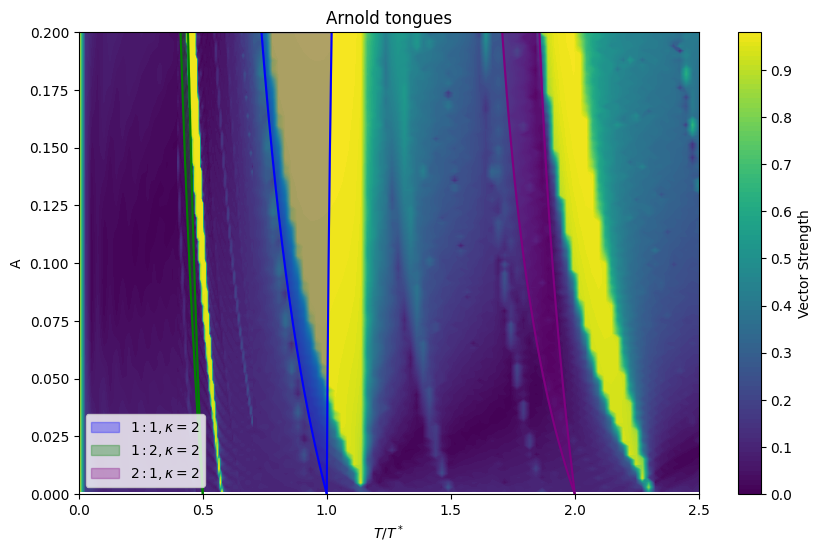

In [31]:
#Comparison of the tongues obtained by the vector strength and the original ones
# Loading data back
A_common = np.load("A_common.npy")
T_values_left_interp = np.load("T_values_left_interp.npy")
T_values_right_interp = np.load("T_values_right_interp.npy")
T_values_left_interp_1 = np.load("T_values_left_interp_1.npy")
T_values_right_interp_1 = np.load("T_values_right_interp_1.npy")
T_values_left_interp_2 = np.load("T_values_left_interp_2.npy")
T_values_right_interp_2 = np.load("T_values_right_interp_2.npy")

time_points = np.linspace(0, Period, 1000)
interp_values = interp_orbit_iPRC(time_points)  # Evaluate interp_orbit_iPRC

# Combination and plotting
plt.figure(figsize=(10, 6))

# Define A and T values for both grids
A_values = np.linspace(0.001, 0.2, 100)        # 100 points between 0.001 and 0.2 for A
T_values = np.linspace(0, 2.5 * Period, 100)   # 100 points between 0 and 2.5*Period for T
A_values_2 = np.linspace(0.001, 0.2, 100)      # 100 points between 0.001 and 0.2 for A
T_values_2 = np.linspace(0.4*Period, 0.7*Period, 50)  # 50 points between 0.4*Period and 0.7*Period for T

# Create mesh grids for (A, T)
A_mesh, T_mesh = np.meshgrid(A_values, T_values)
A_mesh_2, T_mesh_2 = np.meshgrid(A_values_2, T_values_2)

# Load vector strength values
vector_strength_values = np.load("vector_strength.npy")
vector_strength_values_2 = np.load("vector_strength_2.npy")

# Plot vector strength using color scales
plt.contourf(T_mesh / Period, A_mesh, vector_strength_values, levels=100, cmap='viridis')
plt.contourf(T_mesh_2 / Period, A_mesh_2, vector_strength_values_2, levels=100, cmap='viridis')
plt.colorbar(label='Vector Strength')  # Color bar from 0 to 1
plt.clim(0, 1)                         # Fix color scale limits between 0 and 1

# Arnold tongues and filling between interpolated curves 1:1
plt.plot(T_values_left_interp, A_common, color='blue')
plt.plot(T_values_right_interp, A_common, color='blue')
plt.fill_betweenx(A_common, T_values_left_interp, T_values_right_interp, color='blue', alpha=0.3, label=r'$1:1, \kappa=2$')

# Arnold tongues 1:2
plt.plot(T_values_left_interp_1, A_common, color='green')
plt.plot(T_values_right_interp_1, A_common, color='green')
plt.fill_betweenx(A_common, T_values_left_interp_1, T_values_right_interp_1, color='green', alpha=0.3, label=r'$1:2, \kappa=2$')

# Arnold tongues 2:1
plt.plot(T_values_left_interp_2, A_common, color='purple')
plt.plot(T_values_right_interp_2, A_common, color='purple')
plt.fill_betweenx(A_common, T_values_left_interp_2, T_values_right_interp_2, color='purple', alpha=0.3, label=r'$2:1, \kappa=2$')

# Final plot configuration
plt.xlim(0, 2.5)
plt.ylim(0, 0.2)
plt.xlabel(r'$T/T^*$')
plt.ylabel('A')
plt.title('Arnold tongues')
plt.legend(loc="lower left")
plt.grid(False)
plt.show()
